In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import ExtraTreesClassifier

# Model
import tensorflow as tf
from tensorflow.python import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV,StratifiedKFold,RandomizedSearchCV

from tqdm import tqdm

In [20]:
def add_feature_score_to_df(df, feature, score):
    to_append = [feature, score]
    a_series = pd.Series(to_append, index = df.columns)
    df = df.append(a_series, ignore_index=True)

    return df

In [21]:
def execute_extra_trees(X, feature_list):
    X = X[feature_list]

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

    et_clf = ExtraTreesClassifier(n_estimators = 150,
                                  random_state = 42)

    et_clf.fit(X_train, y_train)

    score = et_clf.score(X_val, y_val)
    string = " ".join(feature_list)

    return[string, score]

In [2]:
seed = 42

## Import Data

In [3]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
submission_df = pd.read_csv("sample_submit.csv", names=['id', 'pred'])

In [4]:
train_df = train_df.drop(['id'], axis=1)
test_df = test_df.drop(['id'], axis=1)

## Explore Data

In [81]:
train_df.describe()

,Age,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease,B_Bil,AST_ALT_ratio
count,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000
mean,45.325429,1.919269,0.709048,225.932791,39.925959,39.089220,6.485785,3.612211,0.878517,0.413143,1.210221,1.403685
std,15.817554,3.330010,1.783347,184.208038,120.534839,53.627868,0.871500,0.713799,0.230845,0.492468,2.085226,1.149326
min,3.000000,0.553789,0.040161,129.185799,7.150973,10.565631,3.288138,1.884264,0.366190,0.000000,-15.515488,0.056378
25%,33.000000,0.841287,0.142479,164.143621,15.777688,16.317539,6.019990,3.036498,0.730434,0.000000,0.661108,0.962301
50%,48.000000,0.930300,0.182612,174.094572,18.228538,20.736926,6.596425,3.619430,0.957417,0.000000,0.755731,1.118555
75%,58.000000,1.161300,0.335234,188.749662,24.438192,38.513803,7.140297,4.237270,0.998466,1.000000,0.882945,1.538374
max,75.000000,27.310913,16.300769,1866.147334,1645.254290,577.200793,8.046774,4.701661,2.651567,1.000000,25.362453,17.255315


## Clean Data (Get rid of negative values)

In [6]:
def clean_df(df):
    #Male = 1, Female = 0
    df.loc[df['Gender'] == "Male", 'Gender'] = 0
    df.loc[df['Gender'] == "Female", 'Gender'] = 1
    
    a = list(df.columns)
    a.remove("Gender")
    try:
        a.remove("disease")
    except:
        pass

    for i in a:
        mean = df[i].mean()
        df.loc[df[i] <= 0, i] = mean

    return df

In [7]:
train_df = clean_df(train_df)
test_df = clean_df(test_df)

## Feature Engineering

In [8]:
# 関節ビル(B_Bil)　＋　直接ビル(D_Bil)　＝　総ビル(T_Bil)
train_df["B_Bil"] = train_df["T_Bil"].values - train_df["D_Bil"].values
test_df["B_Bil"] = test_df["T_Bil"].values - test_df["D_Bil"].values

In [9]:
# if abs(AST / ALT) > 0 then bad
train_df["AST_ALT_ratio"] = abs(train_df["AST_GOT"].values/train_df["ALT_GPT"].values)
test_df["AST_ALT_ratio"] = abs(test_df["AST_GOT"].values/test_df["ALT_GPT"].values)

## Clean Data (Normalize)

In [10]:
def normalize_df(df):
    df = (df-df.min())/(df.max()-df.min())
    return df

In [11]:
df = normalize_df(train_df)
df["Gender"] = df["Gender"].astype(str).astype(float)
test_df = normalize_df(test_df)
test_df["Gender"] = test_df["Gender"].astype(str).astype(float)

## Feature Selection

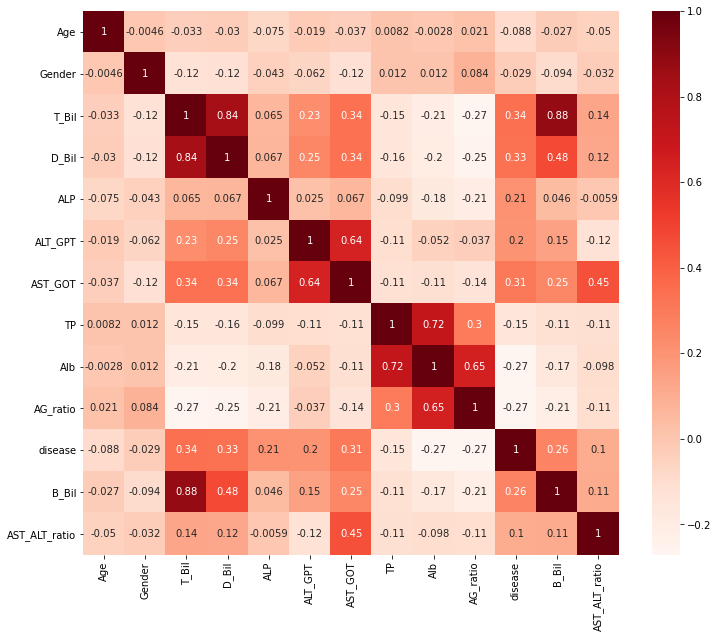

In [12]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

## Create X and y

In [13]:
y = df[["disease"]]

In [14]:
y = y.astype({"disease": int}).values

In [15]:
X = df.drop(["disease"], axis = 1)

In [16]:
X = X.astype({"Gender": int})

In [17]:
y = y.ravel()

## All combinations

In [22]:
import itertools
counter = 0
stuff = list(X.columns)
a = pd.DataFrame(columns = ["features", "score"])
for L in range(0, len(stuff)+1):
    for feature_list in itertools.combinations(stuff, L):
        if len(list(feature_list)) > 5:
            try:
                feature, score = execute_extra_trees(X, list(feature_list))
                a = add_feature_score_to_df(a, feature, score)
            except:
                pass

In [24]:
extra_trees_df = a.copy()

In [39]:
e = extra_trees_df.sort_values(by = "score", ascending = False)

#### Best features = Age Gender T_Bil ALP ALT_GPT TP Alb AG_ratio B_Bil AST_ALT_ratio

In [40]:
e

,features,score
2464,Age Gender T_Bil ALP ALT_GPT TP Alb AG_ratio B...,0.865143
2452,Age Gender T_Bil D_Bil ALT_GPT AST_GOT TP Alb ...,0.865143
2437,Age Gender T_Bil D_Bil ALP ALT_GPT AST_GOT Alb...,0.864000
2345,Age T_Bil D_Bil ALP ALT_GPT Alb AG_ratio B_Bil...,0.861714
2441,Age Gender T_Bil D_Bil ALP ALT_GPT TP Alb AG_r...,0.860571
...,...,...
1126,Age Gender ALP ALT_GPT AST_GOT Alb AST_ALT_ratio,0.749714
159,Age Gender ALP AST_GOT Alb AG_ratio,0.749714
183,Age Gender ALT_GPT AST_GOT AG_ratio AST_ALT_ratio,0.748571
661,Gender ALP ALT_GPT AST_GOT TP AST_ALT_ratio,0.747429


In [42]:
e.iloc[0][0]

'Age Gender T_Bil ALP ALT_GPT TP Alb AG_ratio B_Bil AST_ALT_ratio'

## Train Test Split

In [48]:
X.columns

Index(['Age', 'Gender', 'T_Bil', 'D_Bil', 'ALP', 'ALT_GPT', 'AST_GOT', 'TP',
       'Alb', 'AG_ratio', 'B_Bil', 'AST_ALT_ratio'],
      dtype='object')

In [49]:
X_best = X[["Age", "Gender", "T_Bil", "ALP" ,"ALT_GPT" ,"TP", "Alb", "AG_ratio" ,"B_Bil" ,"AST_ALT_ratio"]]

In [53]:
X_train, X_val, y_train, y_val = train_test_split(X_best, y, test_size=0.25, random_state=42)

## A. Training the Model (Logistic Regression)

In [55]:
from sklearn.pipeline import Pipeline
logReg_clf = LogisticRegression()
logReg_model = Pipeline(steps = [("classifier", logReg_clf)])

logReg_model.fit(X_train, y_train)

score = logReg_model.score(X_val, y_val)

print("Accuracy:", score)

Accuracy: 0.7222857142857143


## B. Training Model (Naives Bayes)

In [56]:
# Fitting a simple Naive Bayes on Counts
naiveBayes_model = MultinomialNB()

naiveBayes_model.fit(X_train, y_train)

score = naiveBayes_model.score(X_val, y_val)

print("Accuracy:", score)

Accuracy: 0.6857142857142857


## D. Training Model (Random Forest)

In [57]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=200,
                                random_state = seed)
rf_model = Pipeline(steps = [("classifier", rf_clf)])

rf_model.fit(X_train, y_train)

score = rf_model.score(X_val, y_val)

print("Accuracy:", score)

Accuracy: 0.8514285714285714


## E. Traning Model (Linear Support Vector Classification)

In [58]:
from sklearn.svm import LinearSVC

svc_clf = LinearSVC(max_iter = 1000,
                    random_state = seed)

svc_clf.fit(X_train, y_train)

score = svc_clf.score(X_val, y_val)

print("Accuracy:", score)

Accuracy: 0.7325714285714285


## F. Training Model (Extra Trees Classifier)

In [59]:
from sklearn.ensemble import ExtraTreesClassifier

et_clf = ExtraTreesClassifier(n_estimators = 500,
                              random_state = seed)

et_clf.fit(X_train, y_train)

score = et_clf.score(X_val, y_val)

print("Accuracy:", score)

Accuracy: 0.8605714285714285


## Confusion Matrix

In [60]:
# Logistic Regression
y_pred_lg_val = logReg_model.predict(X_val)
a,b,c,d = confusion_matrix(y_val, y_pred_lg_val).ravel()
print(a, b)
print(c, d)
print("correct:",str(a+d), "incorrect:",str(b+c))

480 37
206 152
correct: 632 incorrect: 243


In [61]:
# Naives Bayes
y_pred_naive_val = naiveBayes_model.predict(X_val)
a,b,c,d = confusion_matrix(y_val, y_pred_naive_val).ravel()
print(a, b)
print(c, d)
print("correct:",str(a+d), "incorrect:",str(b+c))

514 3
272 86
correct: 600 incorrect: 275


In [62]:
# Random Forest
y_pred_rf_val = rf_model.predict(X_val)
a,b,c,d = confusion_matrix(y_val, y_pred_rf_val).ravel()
print(a, b)
print(c, d)
print("correct:",str(a+d), "incorrect:",str(b+c))

461 56
74 284
correct: 745 incorrect: 130


In [63]:
# Support Vector Classification
y_pred_svc_val = svc_clf.predict(X_val)
a,b,c,d = confusion_matrix(y_val, y_pred_svc_val).ravel()
print(a, b)
print(c, d)
print("correct:",str(a+d), "incorrect:",str(b+c))

492 25
209 149
correct: 641 incorrect: 234


In [64]:
# Extra Trees Classifier
y_pred_et_val = et_clf.predict(X_val)
a,b,c,d = confusion_matrix(y_val, y_pred_et_val).ravel()
print(a, b)
print(c, d)
print("correct:",str(a+d), "incorrect:",str(b+c))

464 53
69 289
correct: 753 incorrect: 122


## X. Training the Model (Sequential Model)

In [65]:
input_dim = X_train.shape[1]  # Number of features

seq_model = Sequential()
seq_model.add(Dense(10, input_dim=input_dim, activation='relu'))
seq_model.add(Dense(20, activation='relu'))
seq_model.add(Dropout(0.1))
seq_model.add(Dense(40, activation='relu'))
seq_model.add(Dense(1, activation='sigmoid'))

In [66]:
seq_model.compile(loss='binary_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])
seq_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                110       
_________________________________________________________________
dense_1 (Dense)              (None, 20)                220       
_________________________________________________________________
dropout (Dropout)            (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 41        
Total params: 1,211
Trainable params: 1,211
Non-trainable params: 0
_________________________________________________________________


In [71]:
history2 = seq_model.fit(X_train,
                        y_train,
                        epochs=1000,
                        validation_data=(X_val, y_val),
                        batch_size=512)

Epoch 1/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.3867 - accuracy: 0.8084 - val_loss: 0.4032 - val_accuracy: 0.7989
Epoch 2/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3877 - accuracy: 0.8088 - val_loss: 0.4045 - val_accuracy: 0.8057
Epoch 3/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3906 - accuracy: 0.8088 - val_loss: 0.4019 - val_accuracy: 0.8034
Epoch 4/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3825 - accuracy: 0.8114 - val_loss: 0.4006 - val_accuracy: 0.8080
Epoch 5/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3889 - accuracy: 0.8046 - val_loss: 0.3999 - val_accuracy: 0.8034
Epoch 6/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3856 - accuracy: 0.8076 - val_loss: 0.4006 - val_accuracy: 0.8023
Epoch 7/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3924 - accuracy: 0.8042 - val_loss: 0.4018 - val_accuracy: 0.8057
Epoch 8/1000
6/6 [=

6/6 [==============================] - 0s 5ms/step - loss: 0.3850 - accuracy: 0.8133 - val_loss: 0.3996 - val_accuracy: 0.8057
Epoch 60/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3846 - accuracy: 0.8122 - val_loss: 0.4005 - val_accuracy: 0.8080
Epoch 61/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3887 - accuracy: 0.8088 - val_loss: 0.4017 - val_accuracy: 0.8034
Epoch 62/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3780 - accuracy: 0.8156 - val_loss: 0.4026 - val_accuracy: 0.8091
Epoch 63/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3844 - accuracy: 0.8107 - val_loss: 0.4036 - val_accuracy: 0.7977
Epoch 64/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3868 - accuracy: 0.8046 - val_loss: 0.4067 - val_accuracy: 0.8034
Epoch 65/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3879 - accuracy: 0.8099 - val_loss: 0.4021 - val_accuracy: 0.8069
Epoch 66/1000
6/6 [========

6/6 [==============================] - 0s 5ms/step - loss: 0.3801 - accuracy: 0.8152 - val_loss: 0.4010 - val_accuracy: 0.7966
Epoch 118/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3862 - accuracy: 0.8103 - val_loss: 0.4010 - val_accuracy: 0.8034
Epoch 119/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3816 - accuracy: 0.8122 - val_loss: 0.4005 - val_accuracy: 0.8034
Epoch 120/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3848 - accuracy: 0.8065 - val_loss: 0.4019 - val_accuracy: 0.7943
Epoch 121/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3805 - accuracy: 0.8088 - val_loss: 0.4087 - val_accuracy: 0.8103
Epoch 122/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3830 - accuracy: 0.8076 - val_loss: 0.4081 - val_accuracy: 0.7989
Epoch 123/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3838 - accuracy: 0.8118 - val_loss: 0.4055 - val_accuracy: 0.8091
Epoch 124/1000
6/6 [=

Epoch 175/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3773 - accuracy: 0.8152 - val_loss: 0.3955 - val_accuracy: 0.8091
Epoch 176/1000
6/6 [==============================] - ETA: 0s - loss: 0.3838 - accuracy: 0.82 - 0s 5ms/step - loss: 0.3784 - accuracy: 0.8149 - val_loss: 0.4009 - val_accuracy: 0.8057
Epoch 177/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3826 - accuracy: 0.8175 - val_loss: 0.4089 - val_accuracy: 0.8103
Epoch 178/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3796 - accuracy: 0.8164 - val_loss: 0.4009 - val_accuracy: 0.8046
Epoch 179/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3813 - accuracy: 0.8149 - val_loss: 0.4009 - val_accuracy: 0.8011
Epoch 180/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3769 - accuracy: 0.8118 - val_loss: 0.3984 - val_accuracy: 0.8034
Epoch 181/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3772 - accuracy: 0.8168 - val_

6/6 [==============================] - 0s 4ms/step - loss: 0.3750 - accuracy: 0.8202 - val_loss: 0.3998 - val_accuracy: 0.8000
Epoch 233/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3809 - accuracy: 0.8126 - val_loss: 0.3987 - val_accuracy: 0.8023
Epoch 234/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3798 - accuracy: 0.8190 - val_loss: 0.4016 - val_accuracy: 0.8046
Epoch 235/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3770 - accuracy: 0.8198 - val_loss: 0.4078 - val_accuracy: 0.8046
Epoch 236/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3774 - accuracy: 0.8156 - val_loss: 0.4052 - val_accuracy: 0.8069
Epoch 237/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3747 - accuracy: 0.8202 - val_loss: 0.4042 - val_accuracy: 0.8057
Epoch 238/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3790 - accuracy: 0.8171 - val_loss: 0.4016 - val_accuracy: 0.8023
Epoch 239/1000
6/6 [=

Epoch 290/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3766 - accuracy: 0.8183 - val_loss: 0.3979 - val_accuracy: 0.8091
Epoch 291/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3773 - accuracy: 0.8156 - val_loss: 0.3986 - val_accuracy: 0.8091
Epoch 292/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3728 - accuracy: 0.8156 - val_loss: 0.3991 - val_accuracy: 0.8114
Epoch 293/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3714 - accuracy: 0.8267 - val_loss: 0.3970 - val_accuracy: 0.8091
Epoch 294/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3724 - accuracy: 0.8213 - val_loss: 0.3991 - val_accuracy: 0.8080
Epoch 295/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3756 - accuracy: 0.8149 - val_loss: 0.3976 - val_accuracy: 0.8080
Epoch 296/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3782 - accuracy: 0.8133 - val_loss: 0.3957 - val_accuracy: 0.8080
Epoch 

Epoch 348/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3695 - accuracy: 0.8213 - val_loss: 0.4002 - val_accuracy: 0.8080
Epoch 349/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3752 - accuracy: 0.8213 - val_loss: 0.4014 - val_accuracy: 0.8034
Epoch 350/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3741 - accuracy: 0.8183 - val_loss: 0.4002 - val_accuracy: 0.8080
Epoch 351/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3650 - accuracy: 0.8251 - val_loss: 0.3970 - val_accuracy: 0.8103
Epoch 352/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3676 - accuracy: 0.8179 - val_loss: 0.3985 - val_accuracy: 0.8114
Epoch 353/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3678 - accuracy: 0.8263 - val_loss: 0.4008 - val_accuracy: 0.8160
Epoch 354/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3777 - accuracy: 0.8168 - val_loss: 0.3975 - val_accuracy: 0.8091
Epoch 

Epoch 406/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3657 - accuracy: 0.8213 - val_loss: 0.3982 - val_accuracy: 0.8126
Epoch 407/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3719 - accuracy: 0.8213 - val_loss: 0.4022 - val_accuracy: 0.8091
Epoch 408/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3709 - accuracy: 0.8244 - val_loss: 0.4004 - val_accuracy: 0.8149
Epoch 409/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3672 - accuracy: 0.8217 - val_loss: 0.3999 - val_accuracy: 0.8137
Epoch 410/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3683 - accuracy: 0.8240 - val_loss: 0.3992 - val_accuracy: 0.8091
Epoch 411/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3706 - accuracy: 0.8198 - val_loss: 0.3983 - val_accuracy: 0.8114
Epoch 412/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3670 - accuracy: 0.8255 - val_loss: 0.3966 - val_accuracy: 0.8160
Epoch 

Epoch 464/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3666 - accuracy: 0.8251 - val_loss: 0.3970 - val_accuracy: 0.8171
Epoch 465/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3698 - accuracy: 0.8229 - val_loss: 0.4002 - val_accuracy: 0.8103
Epoch 466/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3751 - accuracy: 0.8206 - val_loss: 0.4028 - val_accuracy: 0.8103
Epoch 467/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3685 - accuracy: 0.8225 - val_loss: 0.4072 - val_accuracy: 0.8046
Epoch 468/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3718 - accuracy: 0.8210 - val_loss: 0.4021 - val_accuracy: 0.8126
Epoch 469/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3657 - accuracy: 0.8248 - val_loss: 0.4028 - val_accuracy: 0.8137
Epoch 470/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3711 - accuracy: 0.8198 - val_loss: 0.3966 - val_accuracy: 0.8137
Epoch 

Epoch 522/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3671 - accuracy: 0.8278 - val_loss: 0.4001 - val_accuracy: 0.8091
Epoch 523/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3671 - accuracy: 0.8232 - val_loss: 0.3992 - val_accuracy: 0.8103
Epoch 524/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3644 - accuracy: 0.8282 - val_loss: 0.3989 - val_accuracy: 0.8126
Epoch 525/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3644 - accuracy: 0.8259 - val_loss: 0.3984 - val_accuracy: 0.8194
Epoch 526/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3701 - accuracy: 0.8152 - val_loss: 0.4004 - val_accuracy: 0.8149
Epoch 527/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3669 - accuracy: 0.8255 - val_loss: 0.4030 - val_accuracy: 0.8160
Epoch 528/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3716 - accuracy: 0.8240 - val_loss: 0.3996 - val_accuracy: 0.8103
Epoch 

Epoch 580/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3672 - accuracy: 0.8251 - val_loss: 0.4003 - val_accuracy: 0.8137
Epoch 581/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3639 - accuracy: 0.8290 - val_loss: 0.4018 - val_accuracy: 0.8126
Epoch 582/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3665 - accuracy: 0.8225 - val_loss: 0.4035 - val_accuracy: 0.8126
Epoch 583/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3644 - accuracy: 0.8236 - val_loss: 0.4009 - val_accuracy: 0.8137
Epoch 584/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3775 - accuracy: 0.8210 - val_loss: 0.4060 - val_accuracy: 0.8069
Epoch 585/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3738 - accuracy: 0.8229 - val_loss: 0.4088 - val_accuracy: 0.8069
Epoch 586/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3780 - accuracy: 0.8198 - val_loss: 0.4034 - val_accuracy: 0.8126
Epoch 

Epoch 638/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3601 - accuracy: 0.8339 - val_loss: 0.3974 - val_accuracy: 0.8240
Epoch 639/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3701 - accuracy: 0.8190 - val_loss: 0.3985 - val_accuracy: 0.8194
Epoch 640/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3590 - accuracy: 0.8297 - val_loss: 0.3982 - val_accuracy: 0.8183
Epoch 641/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3618 - accuracy: 0.8320 - val_loss: 0.4050 - val_accuracy: 0.8160
Epoch 642/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3731 - accuracy: 0.8229 - val_loss: 0.4103 - val_accuracy: 0.8034
Epoch 643/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3601 - accuracy: 0.8263 - val_loss: 0.4013 - val_accuracy: 0.8171
Epoch 644/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3665 - accuracy: 0.8267 - val_loss: 0.4063 - val_accuracy: 0.8080
Epoch 

Epoch 696/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3632 - accuracy: 0.8301 - val_loss: 0.4001 - val_accuracy: 0.8183
Epoch 697/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3616 - accuracy: 0.8278 - val_loss: 0.4008 - val_accuracy: 0.8171
Epoch 698/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3685 - accuracy: 0.8274 - val_loss: 0.4003 - val_accuracy: 0.8126
Epoch 699/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3653 - accuracy: 0.8255 - val_loss: 0.3961 - val_accuracy: 0.8194
Epoch 700/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3606 - accuracy: 0.8274 - val_loss: 0.4015 - val_accuracy: 0.8080
Epoch 701/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3646 - accuracy: 0.8297 - val_loss: 0.3987 - val_accuracy: 0.8160
Epoch 702/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3551 - accuracy: 0.8286 - val_loss: 0.4063 - val_accuracy: 0.8103
Epoch 

Epoch 754/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3637 - accuracy: 0.8274 - val_loss: 0.3969 - val_accuracy: 0.8206
Epoch 755/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3592 - accuracy: 0.8236 - val_loss: 0.4021 - val_accuracy: 0.8149
Epoch 756/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3595 - accuracy: 0.8392 - val_loss: 0.4020 - val_accuracy: 0.8160
Epoch 757/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3649 - accuracy: 0.8251 - val_loss: 0.4011 - val_accuracy: 0.8183
Epoch 758/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3574 - accuracy: 0.8305 - val_loss: 0.3977 - val_accuracy: 0.8183
Epoch 759/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3653 - accuracy: 0.8293 - val_loss: 0.3964 - val_accuracy: 0.8137
Epoch 760/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3554 - accuracy: 0.8301 - val_loss: 0.3941 - val_accuracy: 0.8194
Epoch 

Epoch 812/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3553 - accuracy: 0.8350 - val_loss: 0.4011 - val_accuracy: 0.8114
Epoch 813/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3613 - accuracy: 0.8320 - val_loss: 0.3955 - val_accuracy: 0.8149
Epoch 814/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3600 - accuracy: 0.8278 - val_loss: 0.3939 - val_accuracy: 0.8183
Epoch 815/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3534 - accuracy: 0.8370 - val_loss: 0.3931 - val_accuracy: 0.8206
Epoch 816/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3639 - accuracy: 0.8255 - val_loss: 0.3942 - val_accuracy: 0.8171
Epoch 817/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3600 - accuracy: 0.8297 - val_loss: 0.3988 - val_accuracy: 0.8171
Epoch 818/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3585 - accuracy: 0.8358 - val_loss: 0.3999 - val_accuracy: 0.8149
Epoch 

Epoch 870/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3592 - accuracy: 0.8324 - val_loss: 0.3937 - val_accuracy: 0.8171
Epoch 871/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3558 - accuracy: 0.8358 - val_loss: 0.3978 - val_accuracy: 0.8217
Epoch 872/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3664 - accuracy: 0.8267 - val_loss: 0.4059 - val_accuracy: 0.8171
Epoch 873/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3667 - accuracy: 0.8293 - val_loss: 0.3947 - val_accuracy: 0.8206
Epoch 874/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3546 - accuracy: 0.8347 - val_loss: 0.3985 - val_accuracy: 0.8194
Epoch 875/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3600 - accuracy: 0.8347 - val_loss: 0.3993 - val_accuracy: 0.8149
Epoch 876/1000
6/6 [==============================] - 0s 6ms/step - loss: 0.3599 - accuracy: 0.8293 - val_loss: 0.3988 - val_accuracy: 0.8206
Epoch 

Epoch 928/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3644 - accuracy: 0.8236 - val_loss: 0.4029 - val_accuracy: 0.8171
Epoch 929/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3659 - accuracy: 0.8301 - val_loss: 0.4087 - val_accuracy: 0.8091
Epoch 930/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3727 - accuracy: 0.8248 - val_loss: 0.3943 - val_accuracy: 0.8171
Epoch 931/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3561 - accuracy: 0.8339 - val_loss: 0.3991 - val_accuracy: 0.8103
Epoch 932/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3582 - accuracy: 0.8270 - val_loss: 0.3990 - val_accuracy: 0.8240
Epoch 933/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3592 - accuracy: 0.8328 - val_loss: 0.3960 - val_accuracy: 0.8160
Epoch 934/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3529 - accuracy: 0.8324 - val_loss: 0.3962 - val_accuracy: 0.8171
Epoch 

Epoch 986/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3578 - accuracy: 0.8297 - val_loss: 0.3987 - val_accuracy: 0.8149
Epoch 987/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3564 - accuracy: 0.8274 - val_loss: 0.3999 - val_accuracy: 0.8126
Epoch 988/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3562 - accuracy: 0.8335 - val_loss: 0.3973 - val_accuracy: 0.8149
Epoch 989/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3557 - accuracy: 0.8328 - val_loss: 0.3991 - val_accuracy: 0.8149
Epoch 990/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3558 - accuracy: 0.8331 - val_loss: 0.3991 - val_accuracy: 0.8183
Epoch 991/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3603 - accuracy: 0.8248 - val_loss: 0.3961 - val_accuracy: 0.8160
Epoch 992/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3522 - accuracy: 0.8339 - val_loss: 0.3999 - val_accuracy: 0.8126
Epoch 

In [68]:
loss, accuracy = seq_model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = seq_model.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.8156
Validation Accuracy:  0.8080


In [69]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

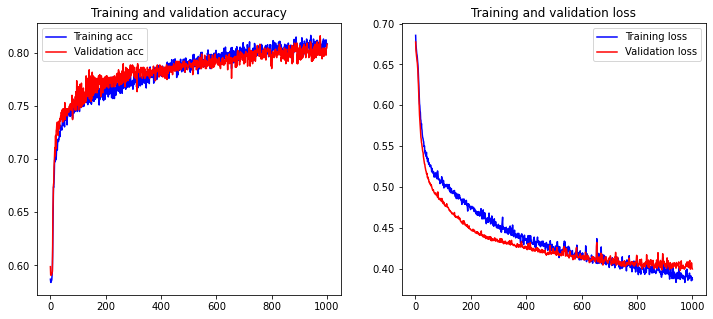

In [70]:
plot_history(history)

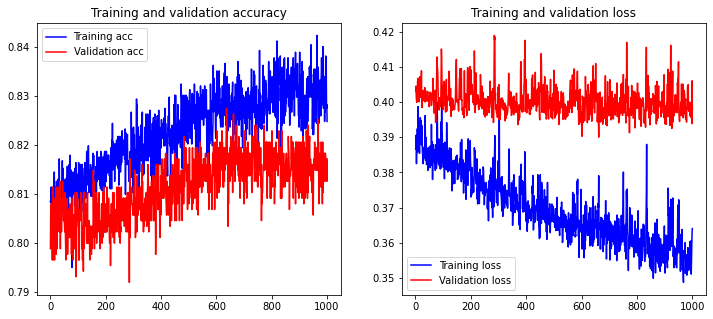

In [72]:
plot_history(history2)

In [73]:
# Sequential Model
y_pred_seq_model = seq_model.predict(X_val)
y_pred_seq = np.round(y_pred_seq_model).astype(int)

In [74]:
a,b,c,d = confusion_matrix(y_val, y_pred_seq).ravel()
print(a, b)
print(c, d)
print("correct:",str(a+d), "incorrect:",str(b+c))

416 101
59 299
correct: 715 incorrect: 160


## Submission

### Submission using Logistic Regression (logReg_model)

In [999]:
submission_df["pred"] = logReg_model.predict(test_df)

In [1000]:
submission_df["pred"].describe()

count    2400.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: pred, dtype: float64

In [ ]:
submission_df.to_csv("output/submission_lr_2.csv", header = False, index=False)

### Submission using Naives Bayes Classifier (naiveBayes_model)

In [ ]:
submission_df["pred"] = naiveBayes_model.predict(test_df)

In [569]:
submission_df.to_csv("output/submission_naive.csv", header = False, index=False)

### Submission using ExtraTrees (et_clf)

In [76]:
test_df_best = test_df[["Age", "Gender", "T_Bil", "ALP" ,"ALT_GPT" ,"TP", "Alb", "AG_ratio" ,"B_Bil" ,"AST_ALT_ratio"]]

In [77]:
submission_df["pred"] = et_clf.predict(test_df_best)

In [78]:
submission_df.to_csv("output/NEW_best_extra_trees.csv", header = False, index=False)

### Submission using Random Forest (rf_model)

In [573]:
submission_df["pred"] = rf_model.predict(test_df)

In [574]:
submission_df.to_csv("output/submission_random.csv", header = False, index=False)

### Sequential Model

In [79]:
y_pred_seq_model = seq_model.predict(test_df_best)
y_pred_seq = np.round(y_pred_seq_model).astype(int)
submission_df["pred"] = y_pred_seq

In [80]:
submission_df.to_csv("output/NEW_best_Seq_model.csv", header = False, index=False)